In [1]:
pip install pandas statsmodels matplotlib

ADF Statistic: -1.333590
p-value: 0.613668
Critical Values:
	1%: -3.535
	5%: -2.907
	10%: -2.591


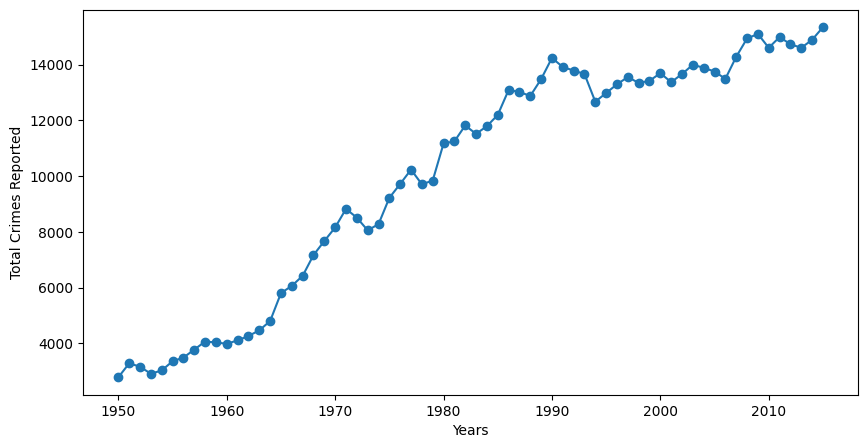

In [9]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Assuming you have a CSV file, replace 'path_to_file.csv' with your file path
# and ensure that column 3 has a header name, for example, 'time_series'
df = pd.read_csv('swedish-crimes.csv')

x = df.iloc[:, 0]  # This is your X-axis values (first column)
y = df.iloc[:, 1]  # This is your Y-axis values (third column)

# Create the plot
plt.figure(figsize=(10,5))  # Adjust the size as you see fit
plt.plot(x, y, marker='o')  # marker is optional

# Optionally, you can add titles and labels
plt.xlabel('Years')
plt.ylabel('Total Crimes Reported')


# Select column 3, assuming it is named 'time_series' or index 2 if it doesn't have a header
time_series = df.iloc[:, 1]  # or df['time_series'] if it has a name

# Apply Dickey-Fuller test
result = adfuller(time_series.dropna())  # Drop NA values in case there are any
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [10]:
# Series is not stationary, we need to apply differencing

# First difference
time_series_diff = time_series.diff().dropna()

# Check the first few elements to ensure the differencing worked
print(time_series_diff.head())

# Apply the ADF test to the differenced data
result_diff = adfuller(time_series_diff)

print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

1    500.0
2   -124.0
3   -251.0
4    119.0
5    329.0
Name: crimes.total, dtype: float64
ADF Statistic: -6.425256
p-value: 0.000000
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592


<Figure size 1000x500 with 0 Axes>

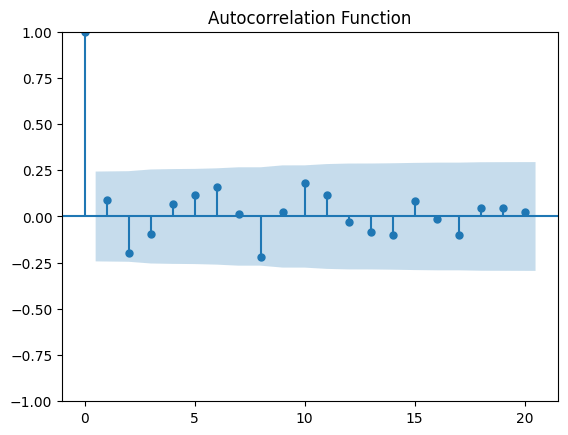

<Figure size 1000x500 with 0 Axes>

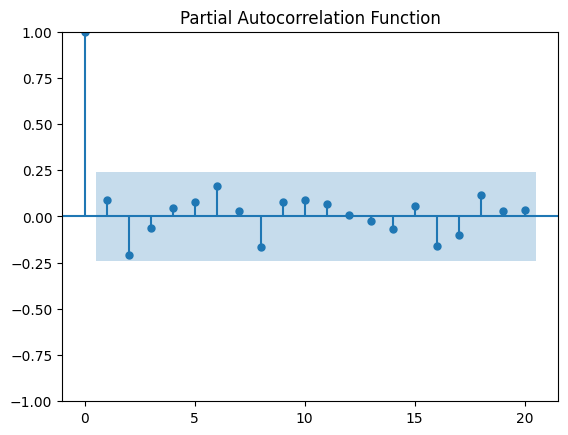

ACF values: [ 1.          0.09115367 -0.19738775 -0.09752007  0.06577446  0.11612609
  0.15813967  0.01119607 -0.21809333  0.02220822  0.18028946  0.11844176
 -0.02773138 -0.08129783 -0.09949493  0.08132928 -0.01585367 -0.10291454
  0.04441123  0.04609346  0.02239584]
PACF values: [ 1.          0.09115367 -0.2074202  -0.05994392  0.04348411  0.07858084
  0.16447505  0.02944944 -0.1663441   0.0794341   0.08917613  0.06725671
  0.00790852 -0.02570396 -0.06806457  0.05464467 -0.16058182 -0.09836784
  0.11615094  0.02995756  0.03508446]


In [11]:
# Now that we have the stationary data we need to find the p and q parameters we will use in our ARIMA model

# Calculate ACF and PACF
lags = 20  # You can change this to how many lags you want to consider
acf_values = acf(time_series_diff, nlags=lags)
pacf_values = pacf(time_series_diff, nlags=lags, method='ywm')  # using Yule-Walker with bias correction

# Plot ACF
plt.figure(figsize=(10, 5))
plot_acf(time_series_diff, lags=lags, alpha=0.05)  # 95% confidence intervals
plt.title('Autocorrelation Function')
plt.show()

# Plot PACF
plt.figure(figsize=(10, 5))
plot_pacf(time_series_diff, lags=lags, alpha=0.05, method='ywm')  # 95% confidence intervals
plt.title('Partial Autocorrelation Function')
plt.show()

# Print out the values
print('ACF values:', acf_values)
print('PACF values:', pacf_values)

In [12]:
import numpy as np

# Define a threshold for which values are considered close to zero
threshold = 0.01  # This can be adjusted based on how strict you want to be

# Find where the ACF and PACF values cross zero
zero_lags_acf = np.where((acf_values[:-1] * acf_values[1:] <= 0))[0]
zero_lags_pacf = np.where((pacf_values[:-1] * pacf_values[1:] <= 0))[0]

print("Lags where ACF crosses zero:", zero_lags_acf)
print("Lags where PACF crosses zero:", zero_lags_pacf)

Lags where ACF crosses zero: [ 1  3  7  8 11 14 15 17]
Lags where PACF crosses zero: [ 1  3  7  8 12 14 15 17]


In [13]:
# Now let's build the ARIMA model, p=3,q=3 seems fine
from statsmodels.tsa.arima.model import ARIMA

# Replace 'd' with the appropriate number of differences you found necessary for stationarity
model = ARIMA(time_series, order=(3, 1, 3))
model_fit = model.fit()

# Forecast the next 5 values
forecast = model_fit.forecast(steps=5)

print(forecast)

66    15364.353716
67    15334.951732
68    15397.156826
69    15563.832261
70    15731.122519
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


*ARIMA model predicts that total crimes reported will keep increasing for the next 5 years, reaching around 13200 by 2020*

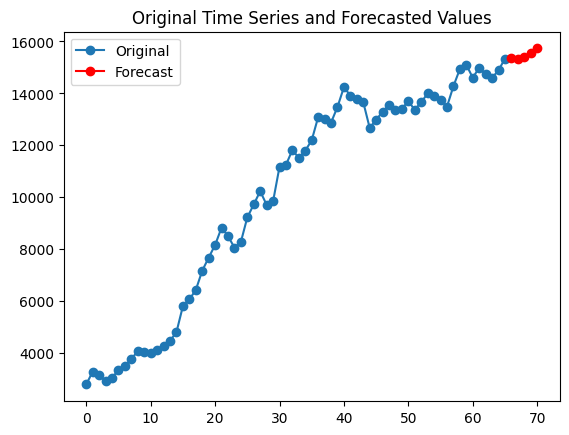

In [14]:
# Plotting the original time series data


plt.plot(time_series, label='Original', marker='o')

# Plotting the forecasted values
# We need to create an index for the forecasted values. Let's assume 'forecast' is a pandas Series.
forecast_index = pd.RangeIndex(start=len(time_series), stop=len(time_series) + len(forecast), step=1)
plt.plot(forecast_index, forecast, color='red', label='Forecast', marker='o')

# Adding a legend to distinguish the datasets
plt.legend()

# Show the plot with a title
plt.title('Original Time Series and Forecasted Values')
plt.show()

In [ ]:
# Let's do the same analysis for the total number of murderers and sexual offences

ADF Statistic: -3.773596
p-value: 0.003189
Critical Values:
	1%: -3.535
	5%: -2.907
	10%: -2.591


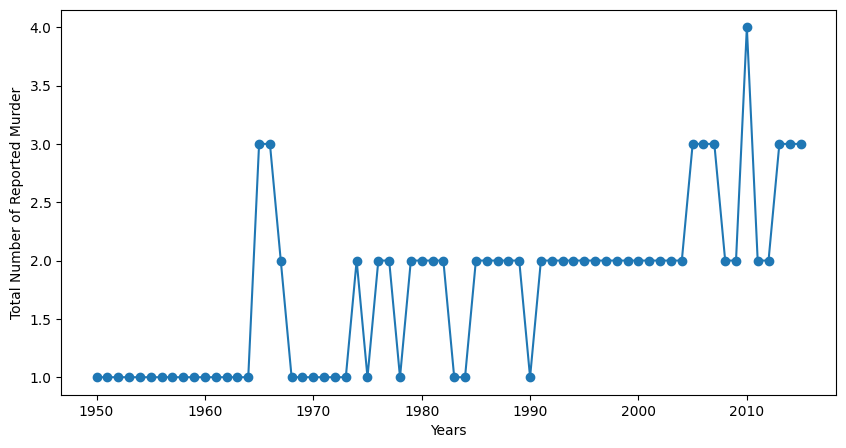

In [15]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Assuming you have a CSV file, replace 'path_to_file.csv' with your file path
# and ensure that column 3 has a header name, for example, 'time_series'
df = pd.read_csv('swedish-crimes.csv')

x = df.iloc[:, 0]  # This is your X-axis values (first column)
y = df.iloc[:, 4]  # This is your Y-axis values (third column)

# Create the plot
plt.figure(figsize=(10,5))  # Adjust the size as you see fit
plt.plot(x, y, marker='o')  # marker is optional

# Optionally, you can add titles and labels
plt.xlabel('Years')
plt.ylabel('Total Number of Reported Murder')


# Select column 3, assuming it is named 'time_series' or index 2 if it doesn't have a header
time_series = df.iloc[:, 4]  # or df['time_series'] if it has a name

# Apply Dickey-Fuller test
result = adfuller(time_series.dropna())  # Drop NA values in case there are any
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [16]:
#p value indicates the data is stationary, we can apply the model fitting right away

from statsmodels.tsa.arima.model import ARIMA

# Replace 'd' with the appropriate number of differences you found necessary for stationarity
model = ARIMA(time_series, order=(1, 0, 1))
model_fit = model.fit()

# Forecast the next 5 values
forecast = model_fit.forecast(steps=5)

print(forecast)

66    2.689004
67    2.664672
68    2.641025
69    2.618045
70    2.595713
Name: predicted_mean, dtype: float64


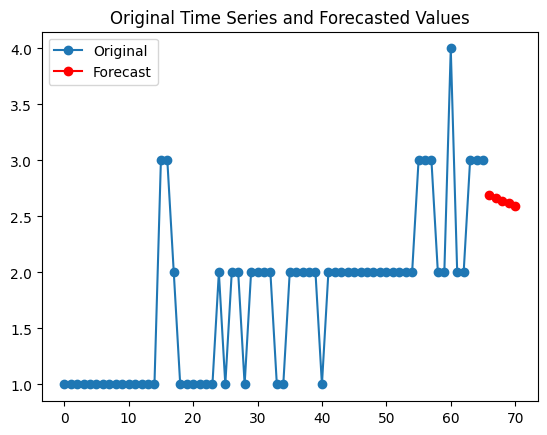

In [17]:
# Plotting the original time series data


plt.plot(time_series, label='Original', marker='o')

# Plotting the forecasted values
# We need to create an index for the forecasted values. Let's assume 'forecast' is a pandas Series.
forecast_index = pd.RangeIndex(start=len(time_series), stop=len(time_series) + len(forecast), step=1)
plt.plot(forecast_index, forecast, color='red', label='Forecast', marker='o')

# Adding a legend to distinguish the datasets
plt.legend()

# Show the plot with a title
plt.title('Original Time Series and Forecasted Values')
plt.show()

ARIMA predicts the total number of murders should be around 2 and 3 for the next five years

ADF Statistic: 1.302225
p-value: 0.996621
Critical Values:
	1%: -3.535
	5%: -2.907
	10%: -2.591


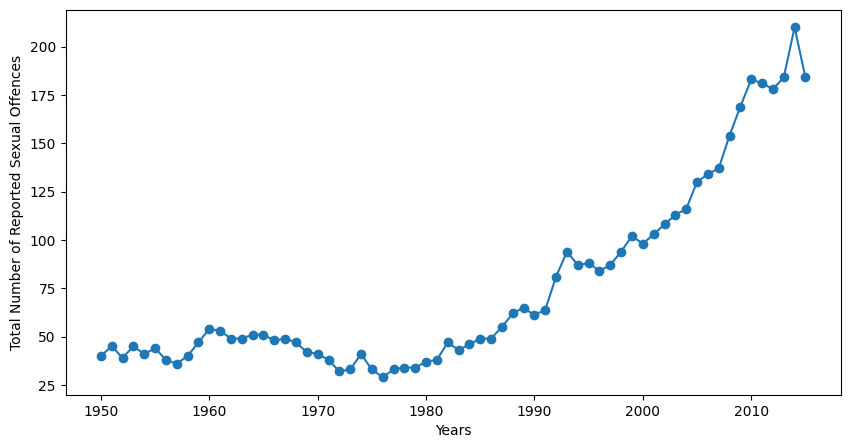

In [19]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Assuming you have a CSV file, replace 'path_to_file.csv' with your file path
# and ensure that column 3 has a header name, for example, 'time_series'
df = pd.read_csv('swedish-crimes.csv')

x = df.iloc[:, 0]  # This is your X-axis values (first column)
y = df.iloc[:, 6]  # This is your Y-axis values (third column)

# Create the plot
plt.figure(figsize=(10,5))  # Adjust the size as you see fit
plt.plot(x, y, marker='o')  # marker is optional

# Optionally, you can add titles and labels
plt.xlabel('Years')
plt.ylabel('Total Number of Reported Sexual Offences')


# Select column 3, assuming it is named 'time_series' or index 2 if it doesn't have a header
time_series = df.iloc[:, 6]  # or df['time_series'] if it has a name

# Apply Dickey-Fuller test
result = adfuller(time_series.dropna())  # Drop NA values in case there are any
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [20]:
# series is not stationary, let's differentiate

# First difference
time_series_diff = time_series.diff().dropna()

# Check the first few elements to ensure the differencing worked
print(time_series_diff.head())

# Apply the ADF test to the differenced data
result_diff = adfuller(time_series_diff)

print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

1    5.0
2   -6.0
3    6.0
4   -4.0
5    3.0
Name: sexual.offenses, dtype: float64
ADF Statistic: -2.649365
p-value: 0.083218
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.593


In [21]:
# p values is still not below 0.05, need to differentiate again

# series is not stationary, let's differentiate

# First difference
time_series_diff = time_series.diff().diff().dropna()

# Check the first few elements to ensure the differencing worked
print(time_series_diff.head())

# Apply the ADF test to the differenced data
result_diff = adfuller(time_series_diff)

print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

2   -11.0
3    12.0
4   -10.0
5     7.0
6    -9.0
Name: sexual.offenses, dtype: float64
ADF Statistic: -6.214368
p-value: 0.000000
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594


In [22]:
# Now let's build the ARIMA model, p=3,q=3 seems fine
from statsmodels.tsa.arima.model import ARIMA

# Replace 'd' with the appropriate number of differences you found necessary for stationarity
model = ARIMA(time_series, order=(3, 2, 3))
model_fit = model.fit()

# Forecast the next 5 values
forecast = model_fit.forecast(steps=5)

print(forecast)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


66    190.132205
67    198.399991
68    208.199105
69    200.104705
70    218.031084
Name: predicted_mean, dtype: float64


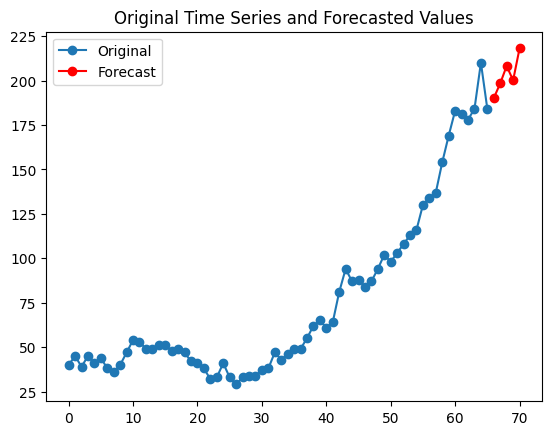

In [23]:
# Plotting the original time series data


plt.plot(time_series, label='Original', marker='o')

# Plotting the forecasted values
# We need to create an index for the forecasted values. Let's assume 'forecast' is a pandas Series.
forecast_index = pd.RangeIndex(start=len(time_series), stop=len(time_series) + len(forecast), step=1)
plt.plot(forecast_index, forecast, color='red', label='Forecast', marker='o')

# Adding a legend to distinguish the datasets
plt.legend()

# Show the plot with a title
plt.title('Original Time Series and Forecasted Values')
plt.show()

Number of sexual offences should grow to around 225 in the next five years